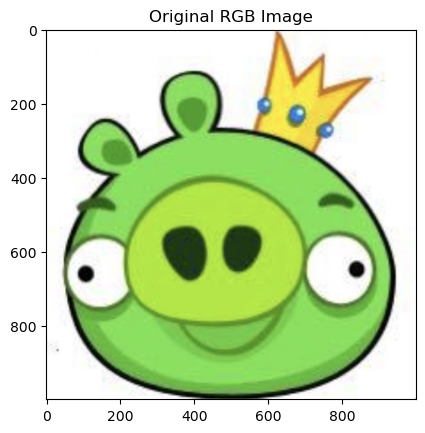

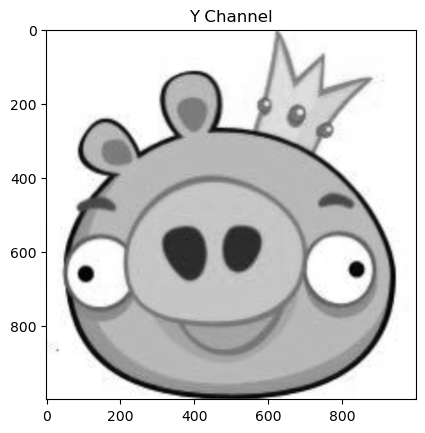

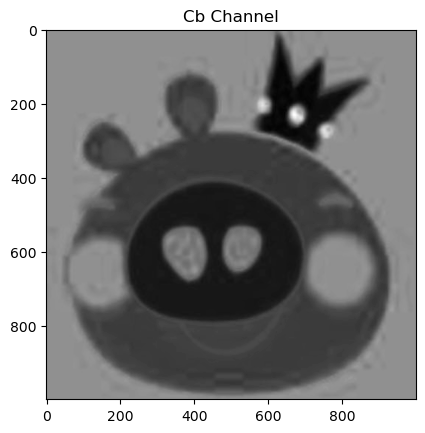

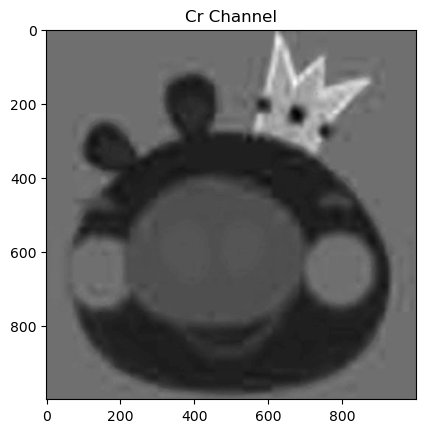

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def rgb2YCbCr(rgb_image):
    r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 128 - 0.168736 * r - 0.331264 * g + 0.5 * b
    cr = 128 + 0.5 * r - 0.418688 * g - 0.081312 * b
    ycbcr_image = np.stack([y, cb, cr], axis=-1)
    return ycbcr_image

# Using matplotlib to read the image
image_path = "/Users/fang/Desktop/zz.jpg"
rgb_image = plt.imread(image_path)

# Get the YCbCr
ycbcr_image = rgb2YCbCr(rgb_image)

# Display the original RGB image
plt.imshow(rgb_image)
plt.title("Original RGB Image")
plt.show()

Y_landscape = ycbcr_image[:, :, 0]
Cb_landscape = ycbcr_image[:, :, 1]
Cr_landscape = ycbcr_image[:, :, 2]
# Display each of the three channels
plt.imshow(Y_landscape, cmap='gray')
plt.title("Y Channel")
plt.show()

plt.imshow(Cb_landscape, cmap='gray')
plt.title("Cb Channel")
plt.show()

plt.imshow(Cr_landscape, cmap='gray')
plt.title("Cr Channel")
plt.show()

# Save the Y image
Y_path = "/Users/fang/Desktop/Y_landscape.jpg"
plt.imsave(Y_path, Y_landscape, cmap='gray')


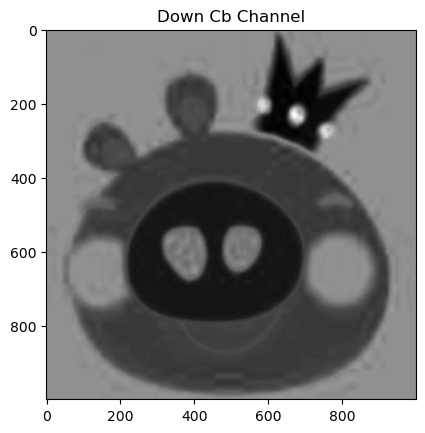

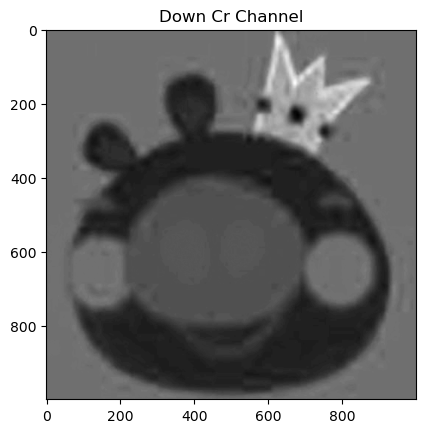

In [2]:
# Step Two: Chrominance Downsampling
Cb_landscape = ycbcr_image[:, :, 1]
Cr_landscape = ycbcr_image[:, :, 2]

# Perform downsampling by averaging 2x2 pixel blocks
def downsample(image_block):
    height, width = len(image_block), len(image_block[0])
    for i in range(0, height - 1, 2):
        for j in range(0, width - 1, 2):
            average_value = sum(image_block[i][j:j+2] + image_block[i+1][j:j+2]) // 4
            image_block[i][j] = average_value
            image_block[i][j+1] = average_value
            image_block[i+1][j] = average_value
            image_block[i+1][j+1] = average_value
    return image_block

Down_Cb_landscape = downsample(Cb_landscape)
Down_Cr_landscape = downsample(Cr_landscape)

plt.imshow(Down_Cb_landscape, cmap='gray')
plt.title("Down Cb Channel")
plt.show()

plt.imshow(Down_Cr_landscape, cmap='gray')
plt.title("Down Cr Channel")
plt.show()

In [63]:
# Step Three: Discrete Cosine Transform and Quantization
import cv2
import numpy as np
import matplotlib.pyplot as plt
block_size = 8
width, height, chanel = rgb_image.shape

quantization_table_for_luminance = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]
quantization_table_for_chrominance = [
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
]


def to_dct_table(block):
    return cv2.dct(np.float32(block)).real.round().astype(np.int32)

# def idct(block):
#     return cv2.idct(np.float32(block)).real.round().astype(np.int32)

def zigzag_encode(block):
    zigzag_order = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
    ]

    zigzag_values = [block[i, j] for i, j in zigzag_order]
    return zigzag_values

def run_length_encode(arr):
    encoded = []
    count = 1
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            count += 1
        else:
            encoded.append(arr[i - 1])
            encoded.append(count)
            count = 1
    encoded.append(arr[-1])
    encoded.append(count)
    return encoded

def block_dct_quantization_zig_runlength_Y(channel, block_size):
    dct_blocks = []
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = channel[i:i+block_size, j:j+block_size]
            if block.shape == (8,8):
                dct_block = to_dct_table(block)
                dct_block = np.true_divide(dct_block, quantization_table_for_luminance).astype(np.int32)
                zigzag_result = zigzag_encode(dct_block)
                dct_block = run_length_encode(zigzag_result)
                dct_blocks.append(dct_block)
    return dct_blocks

def block_dct_quantization_zig_runlength_CrCb(channel, block_size):
    dct_blocks = []
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = channel[i:i+block_size, j:j+block_size]
            if block.shape == (8,8):
                dct_block = to_dct_table(block)
                dct_block = np.true_divide(dct_block, quantization_table_for_chrominance).astype(np.int32)
                zigzag_result = zigzag_encode(dct_block)
                dct_block = run_length_encode(zigzag_result)
                dct_blocks.append(dct_block)
    return dct_blocks

Y_dct_quantization_blocks = block_dct_quantization_zig_runlength_Y(Y_landscape, block_size)
Cr_dct_quantization_blocks = block_dct_quantization_zig_runlength_CrCb(Down_Cr_landscape, block_size)
Cb_dct_quantization_blocks = block_dct_quantization_zig_runlength_CrCb(Down_Cb_landscape, block_size)

for j in [Y_dct_quantization_blocks, Cr_dct_quantization_blocks, Cb_dct_quantization_blocks]:
    total_length = 0
    for i in j:
        total_length += len(i)
    print(total_length)

print('total', 108038+64900+69262)
print('orignal total', 1000*999*3)
# print(Y_dct_quantization_blocks)

108038
64900
69262
total 242200
orignal total 2997000


In [64]:
# For Testing

def zigzag_encode(block):
    zigzag_order = [
        (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
        (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
        (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
        (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
        (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
        (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
        (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
        (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
    ]

    zigzag_values = [block[i, j] for i, j in zigzag_order]
    return zigzag_values

# Example usage:
A = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

zigzag_result = zigzag_encode(A)
print(zigzag_result)


[17, 18, 18, 24, 21, 24, 47, 26, 26, 47, 99, 66, 56, 66, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]


In [49]:
def run_length_encode(arr):
    encoded = []
    count = 1
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            count += 1
        else:
            encoded.append(arr[i - 1])
            encoded.append(count)
            count = 1
    encoded.append(arr[-1])
    encoded.append(count)
    return encoded

print(run_length_encode(zigzag_result))

[17, 1, 18, 2, 24, 1, 21, 1, 24, 1, 47, 1, 26, 2, 47, 1, 99, 1, 66, 1, 56, 1, 66, 1, 99, 50]


In [39]:
print(len([17, 1, 18, 2, 24, 1, 21, 1, 24, 1, 47, 1, 26, 2, 47, 1, 99, 1, 66, 1, 56, 1, 66, 1, 99, 50]))

26


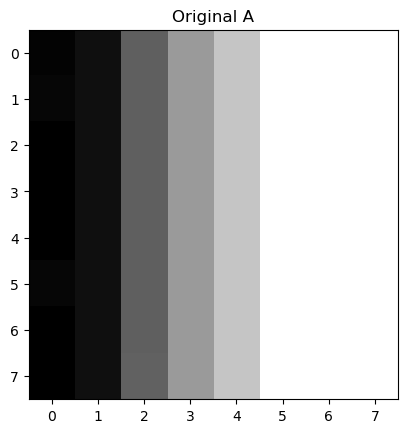

[[ 33 -22  -5   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
[[ 528 -251  -54    8   -4   13   18   -3]
 [   0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    1    1    1    0    0    0]
 [   0    0   -1   -1    0    0    0    0]
 [   0   -1    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0   -1   -1    0    0    0    0    0]]
[33, -22, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[33, 1, -22, 1, 0, 3, -5, 1, 0, 58]


In [68]:
# For Testing
A = np.array([
    [17, 21, 47, 66, 80, 99, 99, 99],
    [18, 21, 47, 66, 80, 99, 99, 99],
    [16, 21, 47, 66, 80, 99, 99, 99],
    [16, 21, 47, 66, 80, 99, 99, 99],
    [16, 21, 47, 66, 80, 99, 99, 99],
    [18, 21, 47, 66, 80, 99, 99, 99],
    [16, 21, 47, 66, 80, 99, 99, 99],
    [16, 21, 48, 66, 80, 99, 99, 99]
])
plt.imshow(A, cmap='gray')
plt.title("Original A")
plt.show()

def to_dct_table(block):
    return cv2.dct(np.float32(block)).real.round().astype(np.int32)

A = to_dct_table(A)
dct_block = np.true_divide(A, quantization_table_for_luminance).astype(np.int32)
print(dct_block)
zigzag_result = zigzag_encode(dct_block)
dct_block = run_length_encode(zigzag_result)

print(A)

print(zigzag_result)
print(dct_block)